In [1]:
!pip -q install -U albumentations
!pip -q uninstall opencv-contrib-python
!pip -q install opencv-contrib-python==4.5.5.64 

     |████████████████████████████████| 113 kB 4.8 MB/s 
     |████████████████████████████████| 48.3 MB 115 kB/s 
Proceed (y/n)? y
     |████████████████████████████████| 66.7 MB 26 kB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!wget -O dataset.zip https://dl.dropboxusercontent.com/s/lc9es5lce77bl5l/SCUT-FBP5500_v2.1.zip?dl=0

--2022-06-19 06:33:37--  https://dl.dropboxusercontent.com/s/lc9es5lce77bl5l/SCUT-FBP5500_v2.1.zip?dl=0
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.3.15, 2620:100:6018:15::a27d:30f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.3.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 179937702 (172M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>] 171.60M   108MB/s    in 1.6s    

2022-06-19 06:33:40 (108 MB/s) - ‘dataset.zip’ saved [179937702/179937702]



In [4]:
!unzip -q /content/dataset.zip -d ./dataset/ && rm /content/dataset.zip

In [5]:
%cd /content/drive/MyDrive/beauty_classification

/content/drive/MyDrive/beauty_classification


In [6]:
import pandas as pd
import numpy as np

from trainer import Trainer, test_model
from utils import define_median_size, check_intensity, softmax
from plots import show_image_tensor, show_images_path, plot_pies
from dataset import People_dataset

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models

from albumentations import Compose
from albumentations.pytorch.transforms import ToTensorV2 
from albumentations.augmentations import transforms as T

import matplotlib.pyplot as plt
import seaborn as sns

import cv2

import os
import random
from collections import Counter
from tqdm import tqdm
from typing import List, Tuple, Any

In [7]:
INPUT_DIR = '/content/dataset/SCUT-FBP5500_v2'
IMAGES_FOLDER_DIR = '/content/dataset/SCUT-FBP5500_v2/Images'

In [8]:
target = pd.read_excel(os.path.join(INPUT_DIR, 'All_Ratings.xlsx'))

In [9]:
target

Rater   Filename  Rating  original Rating
0           1    CF1.jpg       3              NaN
1           1   CF10.jpg       3              NaN
2           1  CF100.jpg       1              NaN
3           1  CF101.jpg       2              NaN
4           1  CF102.jpg       3              NaN
...       ...        ...     ...              ...
329995     60  AM995.jpg       2              NaN
329996     60  AM996.jpg       2              NaN
329997     60  AM997.jpg       3              NaN
329998     60  AM998.jpg       3              NaN
329999     60  AM999.jpg       2              NaN

[330000 rows x 4 columns]

In [10]:
target = target.rename(columns={'Rating': 'R', 'original Rating': 'Orig_R'})

In [11]:
target['Filename'] = target['Filename'].apply(lambda name: os.path.join(IMAGES_FOLDER_DIR, name))

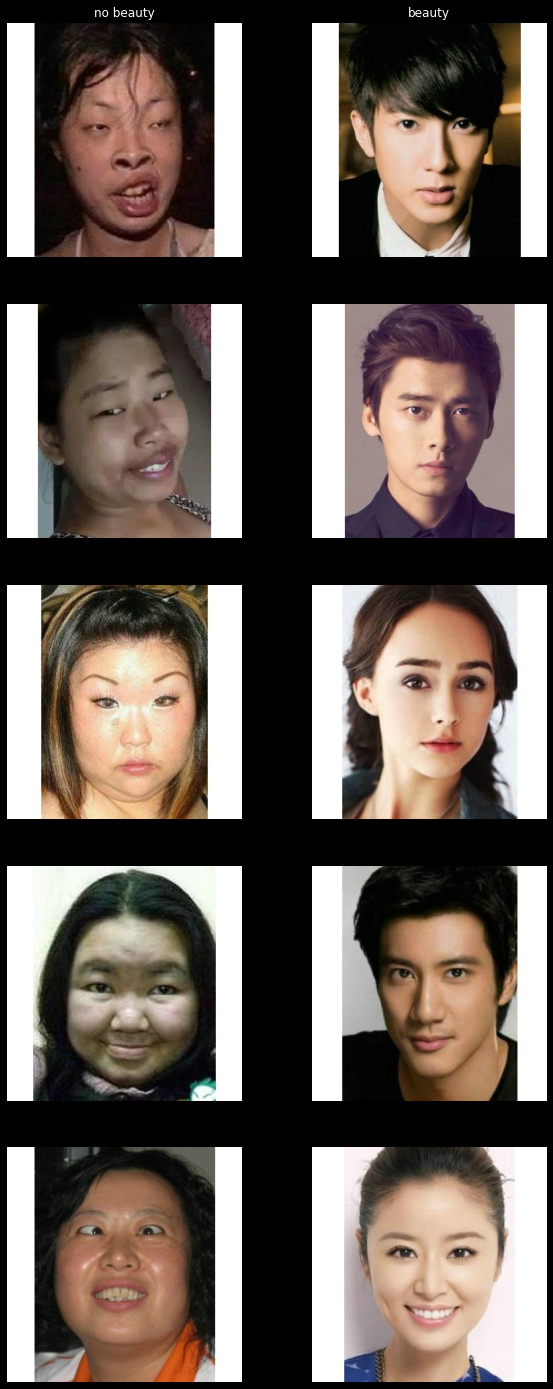

In [12]:
target_mean_r = target.groupby('Filename', as_index=False)['R'].mean()
target_mean_r = target_mean_r.sort_values(by='R')

with plt.style.context('dark_background'):
    show_images_path(paths=[target_mean_r.iloc[:5, 0].array, target_mean_r.iloc[-5:, 0].array],
                     titles=['no beauty', 'beauty'])

In [13]:
def trim_the_edges(path, threshold=400):
    image = cv2.imread(path)
    lost_info = 0

    for left in range(image.shape[1]):
        white_left_info = (image[:, left] == 255).sum()
        lost_info += white_left_info
        if white_left_info < threshold:
            image = image[:, left:]
            break

    for right in range(image.shape[1])[::-1]:
        white_right_info = (image[:, right] == 255).sum()
        lost_info += white_right_info
        if white_right_info < threshold:
            image = image[:, :right]
            break
   
    os.remove(path)
    cv2.imwrite(path, image)
    
    return lost_info

In [14]:
all_lost_info = 0

for image in tqdm(os.listdir(IMAGES_FOLDER_DIR)):
    path = os.path.join(IMAGES_FOLDER_DIR, image)
    all_lost_info += trim_the_edges(path, threshold=500)

print(f'\n{all_lost_info} pixels are lost')

100%|██████████| 5500/5500 [00:25<00:00, 217.89it/s]


467088625 pixels are lost


100%|██████████| 5500/5500 [00:00<00:00, 14612.41it/s]


Number of unique sizes is: 167
Median size is: [263. 350.]
Sizes are: Counter({(261, 350): 151, (251, 350): 143, (250, 350): 137, (249, 350): 130, (271, 350): 126, (275, 350): 121, (253, 350): 112, (267, 350): 112, (270, 350): 108, (263, 350): 107, (255, 350): 104, (259, 350): 102, (262, 350): 98, (283, 350): 96, (260, 350): 96, (272, 350): 94, (279, 350): 94, (269, 350): 91, (257, 350): 85, (273, 350): 85, (265, 350): 84, (254, 350): 81, (239, 350): 80, (252, 350): 77, (274, 350): 76, (256, 350): 75, (248, 350): 72, (268, 350): 70, (247, 350): 68, (264, 350): 66, (287, 350): 64, (266, 350): 64, (282, 350): 63, (281, 350): 63, (258, 350): 62, (241, 350): 61, (278, 350): 61, (277, 350): 60, (291, 350): 57, (280, 350): 56, (240, 350): 54, (243, 350): 54, (245, 350): 54, (242, 350): 54, (238, 350): 53, (276, 350): 52, (246, 350): 51, (293, 350): 50, (285, 350): 47, (229, 350): 42, (286, 350): 42, (230, 350): 40, (237, 350): 40, (244, 350): 39, (299, 350): 38, (284, 350): 38, (295, 350): 3

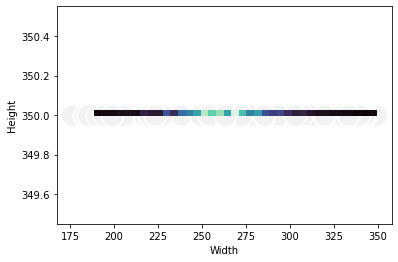

In [15]:
median_size_beauty = define_median_size(paths=[[target['Filename'].unique()]])

In [16]:
print('Number of unique filenames is', target['Filename'].unique().shape[0])
print('Number of unique raters is', target['Rater'].unique().shape[0])
print('Number of grades for each grader is', target.groupby(['Rater'])['Filename'].count().unique())

Number of unique filenames is 5500
Number of unique raters is 60
Number of grades for each grader is [5500]


In [17]:
R_and_Orig_R = target[~target['Orig_R'].isna()][['R', 'Orig_R']]
print('Previous estimates on average differ from the current ones by',
      abs(R_and_Orig_R['R'] - R_and_Orig_R['Orig_R']).mean())

if (R_and_Orig_R['R'] - R_and_Orig_R['Orig_R']).mean() >= 0:
    print('In general, the ratings increased by', (R_and_Orig_R['R'] - R_and_Orig_R['Orig_R']).mean())
else:
    print('In general, the ratings dropped by', (R_and_Orig_R['R'] - R_and_Orig_R['Orig_R']).mean())

Previous estimates on average differ from the current ones by 0.5493506493506494
In general, the ratings increased by 0.17838961038961038


In [18]:
mean_R = (target[~target['Orig_R'].isna()]['R'] + target[~target['Orig_R'].isna()]['Orig_R']) / 2
target.loc[target[~target['Orig_R'].isna()].index, 'R'] = mean_R 

In [19]:
target['R'] = (target['R'] * 2 - 1).astype('int64')   # conversion to a scale from 1 to 9
target.drop('Orig_R', axis=1, inplace=True)
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330000 entries, 0 to 329999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Rater     330000 non-null  int64 
 1   Filename  330000 non-null  object
 2   R         330000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 7.6+ MB


In [20]:
num_classes = len(target['R'].unique())
classes = [str(c) for c in range(1, num_classes + 1)]
print('Number of classes is', num_classes)

Number of classes is 9


In [21]:
target.head()

Rater                                           Filename  R
0      1    /content/dataset/SCUT-FBP5500_v2/Images/CF1.jpg  5
1      1   /content/dataset/SCUT-FBP5500_v2/Images/CF10.jpg  5
2      1  /content/dataset/SCUT-FBP5500_v2/Images/CF100.jpg  1
3      1  /content/dataset/SCUT-FBP5500_v2/Images/CF101.jpg  3
4      1  /content/dataset/SCUT-FBP5500_v2/Images/CF102.jpg  5

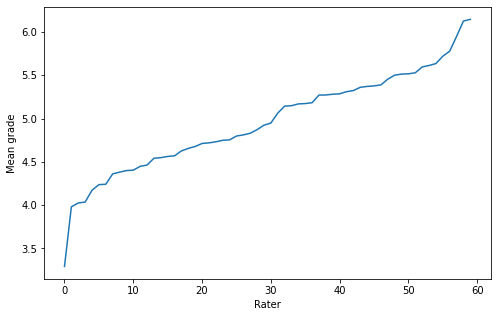

In [22]:
plt.figure(figsize=(8, 5))
sns.lineplot(x=range(len(target['Rater'].unique())),
             y=sorted(target.groupby('Rater')['R'].mean()))
plt.xlabel('Rater')
plt.ylabel('Mean grade');

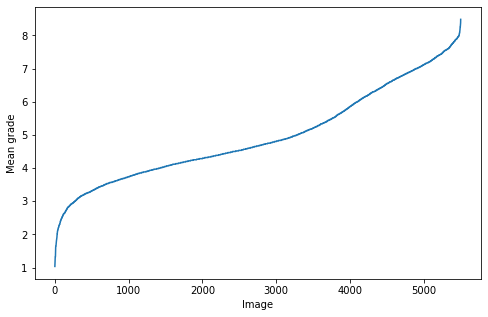

In [23]:
plt.figure(figsize=(8, 5))
sns.lineplot(x=range(len(target['Filename'].unique())),
             y=sorted(target.groupby('Filename')['R'].mean()))
plt.xlabel('Image')
plt.ylabel('Mean grade');

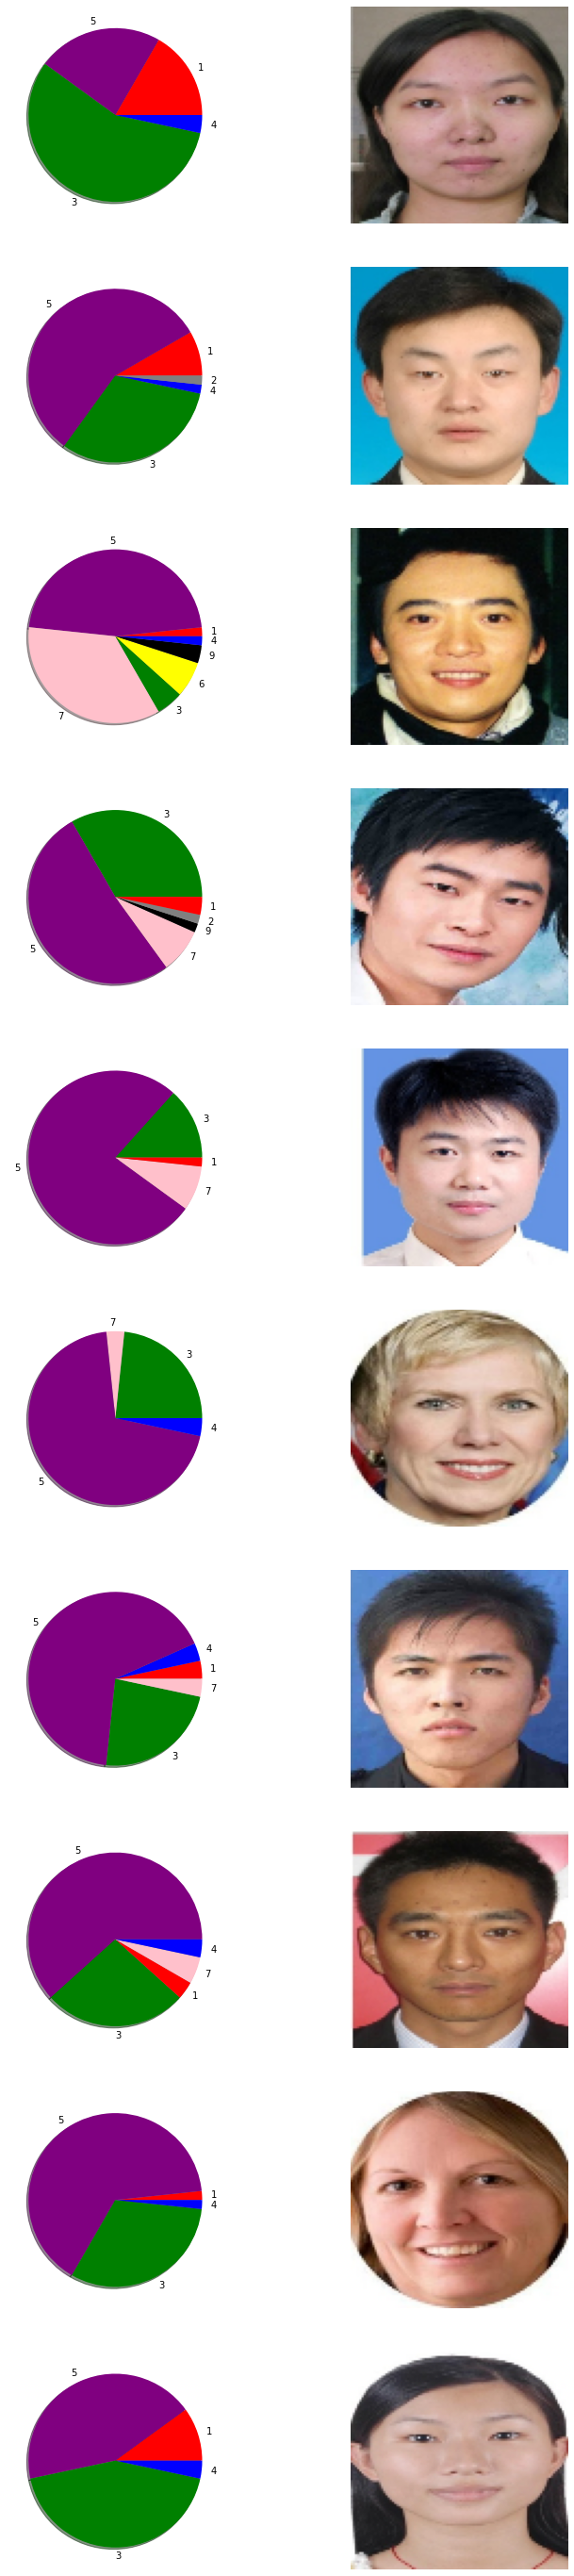

In [24]:
dict_colors = {1: 'red', 2: 'grey', 3: 'green', 4: 'blue',
               5: 'purple', 6: 'yellow', 7: 'pink', 8: 'white',
               9: 'black'}

parts = []
labels = []
paths = []

for _ in range(10):
    path = random.choice(target['Filename'].unique())
    data = target[target['Filename'] == path]

    parts.append(Counter(data['R']).values())
    labels.append(Counter(data['R']).keys())
    paths.append(path)

plot_pies(parts=parts, labels=labels, image_paths=paths, color_dict=dict_colors)

In [25]:
target = target.groupby('Filename', as_index=False)['R'].mean()
target['R'] = target['R'].round().astype('int64')

In [26]:
train_paths, holdout_paths = train_test_split(target['Filename'].array, train_size=0.8)
valid_paths, test_paths = train_test_split(holdout_paths, train_size=0.65)

train_data = target[target['Filename'].isin(train_paths)]
valid_data = target[target['Filename'].isin(valid_paths)]
test_data = target[target['Filename'].isin(test_paths)]

train_by_classes = [target[(target['Filename'].isin(train_paths)) & (target['R'] == r)]['Filename'].array for r in range(1, num_classes)]
valid_by_classes = [target[(target['Filename'].isin(valid_paths)) & (target['R'] == r)]['Filename'].array for r in range(1, num_classes)]
test_by_classes = [target[(target['Filename'].isin(test_paths)) & (target['R'] == r)]['Filename'].array for r in range(1, num_classes)]

print('Train size:', len(train_paths))
print('Valid size:', len(valid_paths))
print('Test size:', len(test_paths))

Train size: 4400
Valid size: 715
Test size: 385


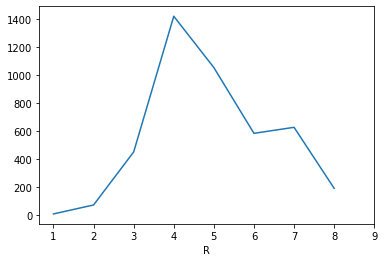

In [27]:
train_data.groupby('R')['Filename'].count().plot()
plt.xticks(range(1, num_classes + 1));

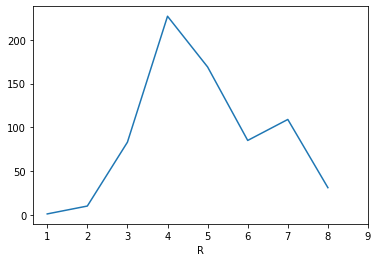

In [28]:
valid_data.groupby('R')['Filename'].count().plot()
plt.xticks(range(1, num_classes + 1));

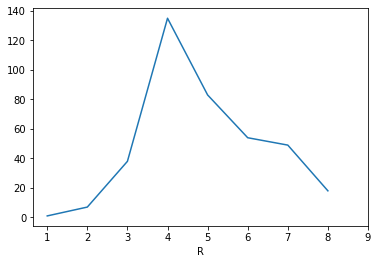

In [29]:
test_data.groupby('R')['Filename'].count().plot()
plt.xticks(range(1, num_classes + 1));

100%|██████████| 4400/4400 [00:04<00:00, 900.42it/s]


Number of black images is: 0
Number of white images is: 0


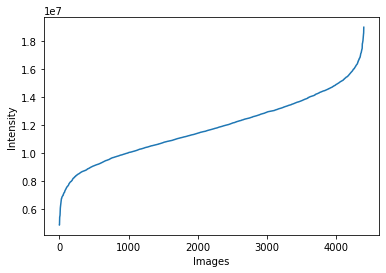

In [30]:
check_intensity([train_paths], resize=median_size_beauty)

100%|██████████| 715/715 [00:00<00:00, 905.44it/s]


Number of black images is: 0
Number of white images is: 0


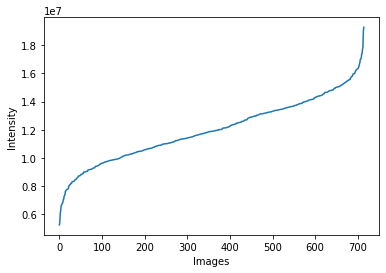

In [31]:
check_intensity([valid_paths], resize=median_size_beauty)

100%|██████████| 385/385 [00:00<00:00, 907.78it/s]


Number of black images is: 0
Number of white images is: 0


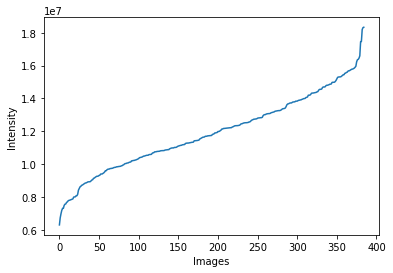

In [32]:
check_intensity([test_paths], resize=median_size_beauty)

In [33]:
test_aug = Compose([T.ColorJitter(p=0.3, brightness=0.2, contrast=0.1),
                    T.Equalize(p=0.3, by_channels=False),
                    T.Flip(p=0.5),
                    T.GaussNoise(p=0.2),
                    T.HorizontalFlip(p=0.5),
                    T.RandomBrightnessContrast(p=0.3, brightness_limit=0.2, contrast_limit=0.05),
                    ToTensorV2()])

In [34]:
test_dataset = People_dataset(paths=train_by_classes,
                              classes=[str(c) for c in range(1, num_classes + 1)],
                              resize=median_size_beauty,
                              transform=test_aug)

1


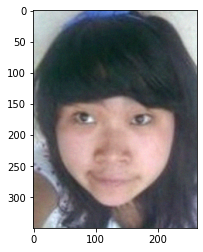

In [35]:
print(test_dataset[23][1])
plt.imshow(test_dataset[23][0].numpy().transpose((1, 2, 0))[:, :, [2, 1, 0]])

In [36]:
train_aug = Compose([T.ColorJitter(p=0.3, brightness=0.2, contrast=0.1),
                    T.Equalize(p=0.3, by_channels=False),
                    T.Flip(p=0.5),
                    T.GaussNoise(p=0.3),
                    T.HorizontalFlip(p=0.5),
                    T.RandomBrightnessContrast(p=0.3, brightness_limit=0.2, contrast_limit=0.05),
                    ToTensorV2()])

valid_aug = Compose([T.Flip(p=0.3),
                     T.GaussNoise(p=0.5),
                     T.HorizontalFlip(p=0.3),
                     ToTensorV2()])

test_aug = ToTensorV2()

In [37]:
train_dataset = People_dataset(paths=train_by_classes,
                               classes=classes,
                               resize=median_size_beauty,
                               transform=train_aug)

valid_dataset = People_dataset(paths=valid_by_classes,
                               classes=classes,
                               resize=median_size_beauty,
                               transform=valid_aug)

test_dataset = People_dataset(paths=test_by_classes,
                              classes=classes,
                              resize=median_size_beauty,
                              transform=test_aug)


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=16,
                          shuffle=True,
                          num_workers=2)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=8,
                          shuffle=True,
                          num_workers=2)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=2,
                         shuffle=True,
                         num_workers=2)

In [38]:
def get_model(title, classes, pretrained, freeze=False):
    if title not in models.__dict__:
        print('Model is not available')
    else:
        model = models.__dict__[title](pretrained=pretrained)
    
    if freeze:
        for param in model.parameters():
            param.requires_grad = False
    
    if title in ['resnet18', 'resnet34', 'resnet152']:
        input_features = model.fc.in_features
        model.fc = nn.Linear(input_features, classes)
        model.fc = nn.Sequential(nn.Dropout(p=0.65), nn.Linear(input_features, classes))

    elif title == 'densenet121':
        input_features = model.classifier.in_features
        model.classifier = nn.Linear(input_features, classes)

    elif title == 'mobilenet_v2':
        input_features = model.classifier[1].out_features
        model.classifier.append(nn.Linear(input_features, classes))

    return model

In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device, 'training')

model = get_model('resnet34', num_classes, pretrained=True)
model.to(device);

cuda training


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [40]:
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_func = CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=3)

In [41]:
trainer = Trainer(model=model,
                  optimizer=optimizer,
                  loss_func=loss_func,
                  num_classes=num_classes,
                  device=device,
                  path_save='saved/beauty_classification.pt')

In [42]:
epochs = 13

In [43]:
trainer.train(train_loader, valid_loader, epochs)

[1/13][valid]: 100%|██████████| 90/90 [00:07<00:00, 12.35it/s, loss=1.03]


____________                                          ____________________
      Train | accuracy: 0.3557   | precision: 0.3557 |
	    | loss: 1.6905	 | recall: 0.3557    |
	      --------------------------------------
      Valid | accuracy: 0.4601   | precision: 0.4601 |
	    | loss: 1.2602	 | recall: 0.4601    |
	      --------------------------------------
__________________________________________________________________________


[2/13][valid]: 100%|██████████| 90/90 [00:08<00:00, 10.35it/s, loss=1.3]


____________                                          ____________________
      Train | accuracy: 0.4141   | precision: 0.4141 |
	    | loss: 1.4532	 | recall: 0.4141    |
	      --------------------------------------
      Valid | accuracy: 0.4741   | precision: 0.4741 |
	    | loss: 1.1751	 | recall: 0.4741    |
	      --------------------------------------
__________________________________________________________________________


[3/13][valid]: 100%|██████████| 90/90 [00:07<00:00, 12.42it/s, loss=1.69]


____________                                          ____________________
      Train | accuracy: 0.4439   | precision: 0.4439 |
	    | loss: 1.3130	 | recall: 0.4439    |
	      --------------------------------------
      Valid | accuracy: 0.4434   | precision: 0.4434 |
	    | loss: 1.2886	 | recall: 0.4434    |
	      --------------------------------------
__________________________________________________________________________


[4/13][valid]: 100%|██████████| 90/90 [00:06<00:00, 13.03it/s, loss=0.434]


____________                                          ____________________
      Train | accuracy: 0.4693   | precision: 0.4693 |
	    | loss: 1.2410	 | recall: 0.4693    |
	      --------------------------------------
      Valid | accuracy: 0.4210   | precision: 0.4210 |
	    | loss: 1.3956	 | recall: 0.4210    |
	      --------------------------------------
__________________________________________________________________________


[5/13][valid]: 100%|██████████| 90/90 [00:07<00:00, 12.46it/s, loss=0.543]


____________                                          ____________________
      Train | accuracy: 0.4757   | precision: 0.4757 |
	    | loss: 1.2018	 | recall: 0.4757    |
	      --------------------------------------
      Valid | accuracy: 0.5175   | precision: 0.5175 |
	    | loss: 1.0563	 | recall: 0.5175    |
	      --------------------------------------
__________________________________________________________________________


[6/13][valid]: 100%|██████████| 90/90 [00:07<00:00, 12.35it/s, loss=0.55]


____________                                          ____________________
      Train | accuracy: 0.4961   | precision: 0.4961 |
	    | loss: 1.1624	 | recall: 0.4961    |
	      --------------------------------------
      Valid | accuracy: 0.4671   | precision: 0.4671 |
	    | loss: 1.2328	 | recall: 0.4671    |
	      --------------------------------------
__________________________________________________________________________


[7/13][valid]: 100%|██████████| 90/90 [00:06<00:00, 12.96it/s, loss=0.501]


____________                                          ____________________
      Train | accuracy: 0.5184   | precision: 0.5184 |
	    | loss: 1.0963	 | recall: 0.5184    |
	      --------------------------------------
      Valid | accuracy: 0.5007   | precision: 0.5007 |
	    | loss: 1.2131	 | recall: 0.5007    |
	      --------------------------------------
__________________________________________________________________________


[8/13][valid]: 100%|██████████| 90/90 [00:07<00:00, 12.67it/s, loss=0.539]


____________                                          ____________________
      Train | accuracy: 0.5386   | precision: 0.5386 |
	    | loss: 1.0674	 | recall: 0.5386    |
	      --------------------------------------
      Valid | accuracy: 0.5483   | precision: 0.5483 |
	    | loss: 1.0637	 | recall: 0.5483    |
	      --------------------------------------
__________________________________________________________________________


[9/13][valid]: 100%|██████████| 90/90 [00:07<00:00, 12.50it/s, loss=0.506]


____________                                          ____________________
      Train | accuracy: 0.5566   | precision: 0.5566 |
	    | loss: 1.0356	 | recall: 0.5566    |
	      --------------------------------------
      Valid | accuracy: 0.5692   | precision: 0.5692 |
	    | loss: 1.0008	 | recall: 0.5692    |
	      --------------------------------------
__________________________________________________________________________


[10/13][valid]: 100%|██████████| 90/90 [00:08<00:00, 10.51it/s, loss=1.16]


____________                                          ____________________
      Train | accuracy: 0.5661   | precision: 0.5661 |
	    | loss: 0.9946	 | recall: 0.5661    |
	      --------------------------------------
      Valid | accuracy: 0.5650   | precision: 0.5650 |
	    | loss: 1.0613	 | recall: 0.5650    |
	      --------------------------------------
__________________________________________________________________________


[11/13][valid]: 100%|██████████| 90/90 [00:07<00:00, 12.80it/s, loss=1.15]


____________                                          ____________________
      Train | accuracy: 0.5773   | precision: 0.5773 |
	    | loss: 0.9801	 | recall: 0.5773    |
	      --------------------------------------
      Valid | accuracy: 0.5580   | precision: 0.5580 |
	    | loss: 1.0464	 | recall: 0.5580    |
	      --------------------------------------
__________________________________________________________________________


[12/13][valid]: 100%|██████████| 90/90 [00:06<00:00, 12.88it/s, loss=0.663]


____________                                          ____________________
      Train | accuracy: 0.5848   | precision: 0.5848 |
	    | loss: 0.9508	 | recall: 0.5848    |
	      --------------------------------------
      Valid | accuracy: 0.5245   | precision: 0.5245 |
	    | loss: 1.1169	 | recall: 0.5245    |
	      --------------------------------------
__________________________________________________________________________


[13/13][valid]: 100%|██████████| 90/90 [00:07<00:00, 12.75it/s, loss=0.371]



____________                                          ____________________
      Train | accuracy: 0.6148   | precision: 0.6148 |
	    | loss: 0.8979	 | recall: 0.6148    |
	      --------------------------------------
      Valid | accuracy: 0.5594   | precision: 0.5594 |
	    | loss: 1.0421	 | recall: 0.5594    |
	      --------------------------------------
__________________________________________________________________________


In [44]:
model = torch.load('saved/beauty_classification.pt', map_location=device)['model']
model.eval();

In [45]:
epochs = len(trainer.history['Train']['loss']) 

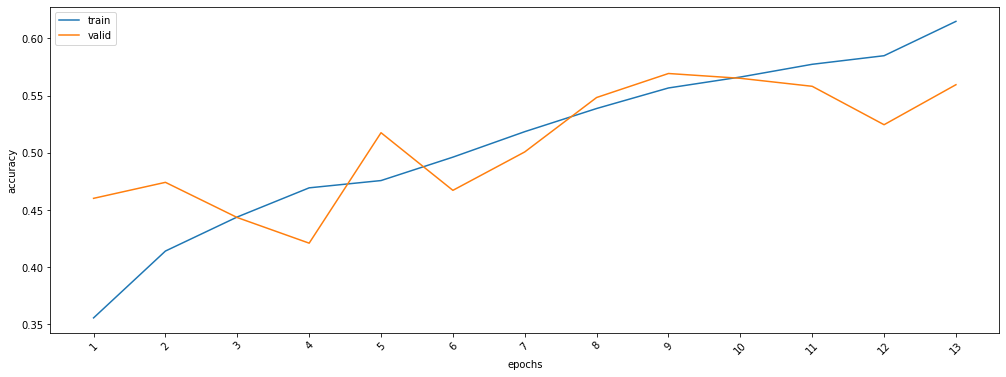

In [46]:
plt.figure(figsize=(17, 6))
sns.lineplot(x=range(1, epochs + 1),
             y=trainer.history['Train']['accuracy'],
             label='train')

sns.lineplot(x=range(1, epochs + 1),
             y=trainer.history['Valid']['accuracy'],
             label='valid')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.xticks(range(1, epochs + 1), rotation=45)
plt.legend()

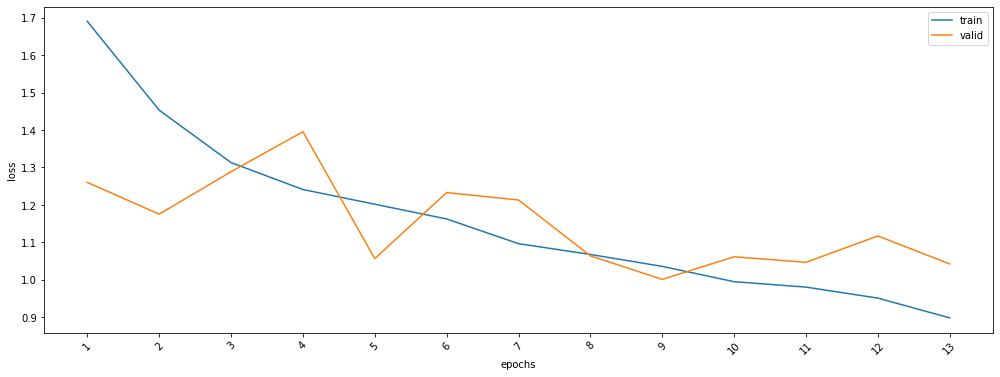

In [47]:
plt.figure(figsize=(17, 6))
sns.lineplot(x=range(1, epochs + 1),
             y=trainer.history['Train']['loss'],
             label='train')

sns.lineplot(x=range(1, epochs + 1),
             y=trainer.history['Valid']['loss'],
             label='valid')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.xticks(range(1, epochs + 1), rotation=45)
plt.legend()

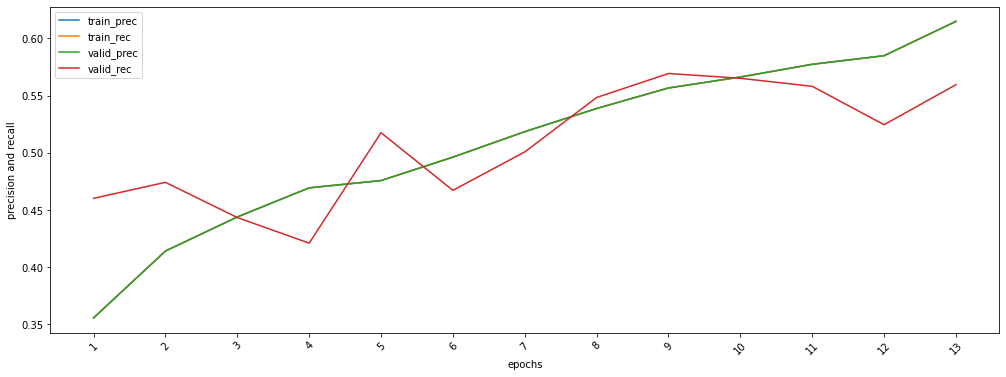

In [48]:
plt.figure(figsize=(17, 6))
sns.lineplot(x=range(1, epochs + 1),
             y=trainer.history['Train']['precision'],
             label='train_prec')
sns.lineplot(x=range(1, epochs + 1),
             y=trainer.history['Train']['recall'],
             label='train_rec')

sns.lineplot(x=range(1, epochs + 1),
             y=trainer.history['Train']['precision'],
             label='valid_prec')
sns.lineplot(x=range(1, epochs + 1),
             y=trainer.history['Valid']['recall'],
             label='valid_rec')

plt.xlabel('epochs')
plt.ylabel('precision and recall')
plt.xticks(range(1, epochs + 1), rotation=45)
plt.legend()

In [49]:
preds_data = test_model(model, test_loader, device)

100%|██████████| 193/193 [00:03<00:00, 57.13it/s]


accuracy: 0.5818181818181818


In [50]:
corrects = 0

for row in preds_data:
    if row[2] in (row[1] - 1, row[1], row[1] + 1):
        corrects += 1

print('Accuracy with error is', corrects / len(preds_data))

Accuracy with error is 0.9688311688311688


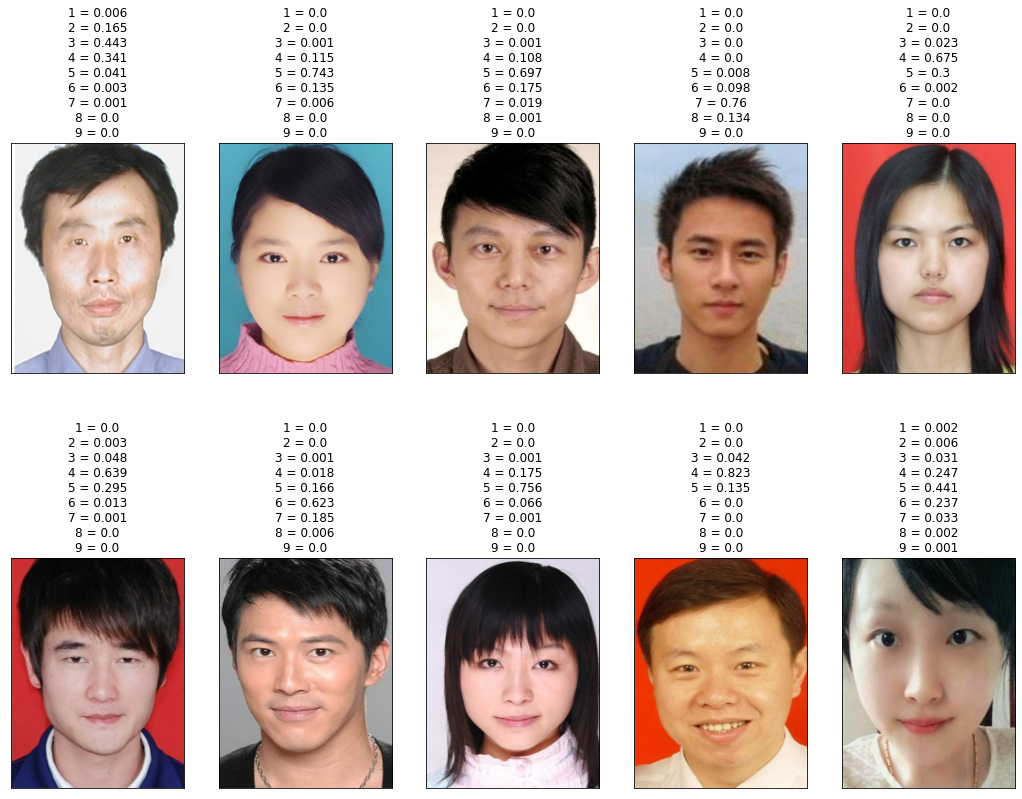

In [51]:
fig = plt.figure(figsize=(18, 14))

for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1)
    i = -i + 100
    show_image_tensor(image=preds_data[i][0],
                      classes_names=classes,
                      probality_classes=preds_data[i][3],
                      sep='\n')

In [66]:
incorrect_preds = [sample for sample in preds_data if sample[2] != sample[1]]
print('Number of samples on test_loader is', len(preds_data))
print('Number of dataset errors on test_loader is', len(incorrect_preds))

Number of samples on test_loader is 385
Number of dataset errors on test_loader is 161


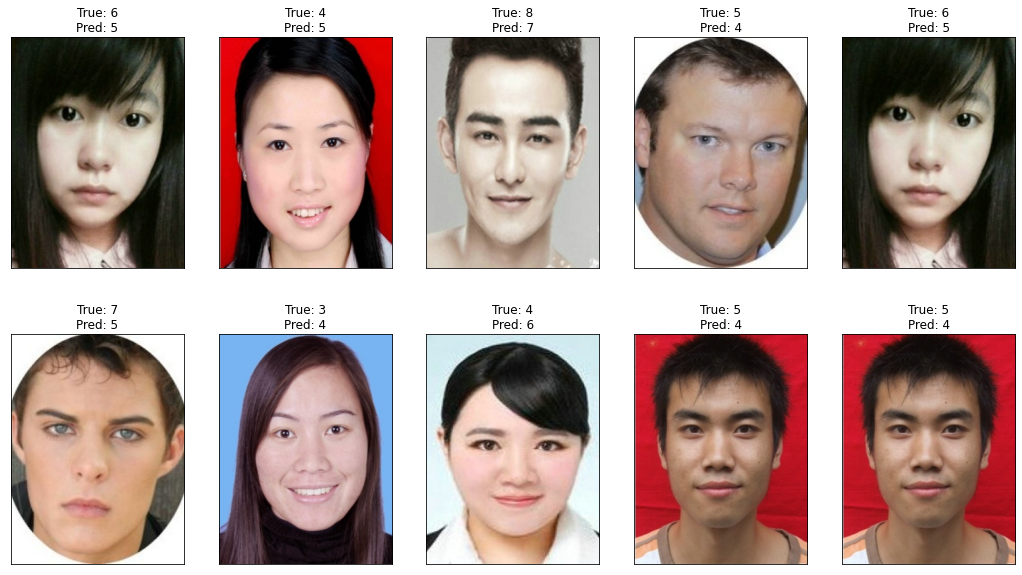

In [67]:
fig = plt.figure(figsize=(18, 10))

for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1)

    i = random.randint(0, len(incorrect_preds) - 1)

    show_image_tensor(image=incorrect_preds[i][0],
                      image_class = f'True: {str(incorrect_preds[i][2].item() + 1)}\n'+
                                    f'Pred: {str(incorrect_preds[i][1].item() + 1)}',
                      sep='\n')

In [68]:
incorrect_preds = [sample for sample in preds_data if sample[2] not in (sample[1] - 1, sample[1], sample[1] + 1)]
print('Number of samples on test_loader is', len(preds_data))
print('Number of dataset errors on test_loader is', len(incorrect_preds))

Number of samples on test_loader is 385
Number of dataset errors on test_loader is 12


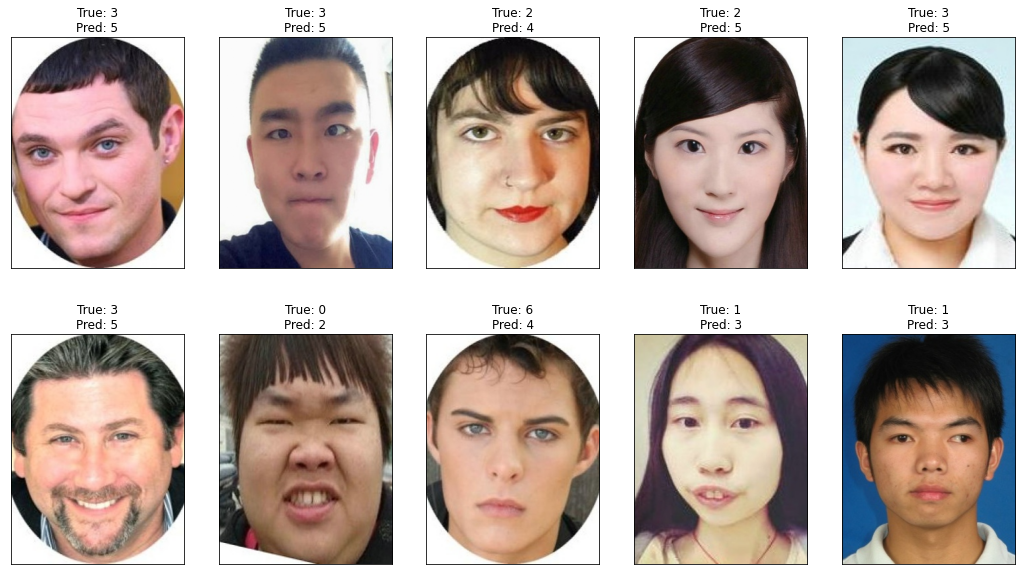

In [69]:
fig = plt.figure(figsize=(18, 10))

for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1)

    if i == len(incorrect_preds):
        break
        
    show_image_tensor(image=incorrect_preds[i][0],
                      image_class = f'True: {str(incorrect_preds[i][2].item())}\n'+
                                    f'Pred: {str(incorrect_preds[i][1].item())}',
                      sep='\n')

In [ ]:
dir_for_classification = 'for_classification/'

n_images = len(os.listdir(dir_for_classification))
print('Number of images is', len(os.listdir(dir_for_classification)))

In [ ]:
images = []

for image_name in os.listdir(dir_for_classification):
    path = os.path.join(dir_for_classification, image_name)

    try:
        image = cv2.imread(path)
        assert image is not None
        image = cv2.resize(image, median_size_beauty, cv2.INTER_AREA)
        images.append(image)
    except:
        print('Error:', path)

In [ ]:
images = torch.from_numpy(np.array(images)) / 255;
images = images.permute((0, 3, 1, 2))

In [ ]:
preds = model(images.to(device))
_, preds = torch.max(preds, axis=1)

In [ ]:
fig = plt.figure(figsize=(8, 8 * n_images))

for i, image, r in zip(range(len(images)), images, preds):
    ax = fig.add_subplot(n_images, 1, i + 1)
    show_image_tensor(image=image, image_class=r.item())